In [1]:
import os
from google.colab import drive
drive.mount('/content/gdrive')
path ='/content/gdrive/My Drive/CIFAR10_ResNet'
if not os.path.exists(path):
  os.mkdir(path)
os.chdir(path)

Mounted at /content/gdrive


establish root path


In [ ]:
# network class: fill in the network class if it is not available in torchvision.models

In [4]:
class MyNetArgs:
   """
    Passing the hyperparameters to the model
   """
   def __init__(self ,epochs=200, start_epoch=0, batch_size=128, lr=0.1, momentum=0.9, weight_decay=1e-4, print_freq=55,
                 evaluate=0,num_classes =10 ,pretrained=0, half=0, save_dir='save_temp', save_every=10):
        self.save_every = save_every #Saves checkpoints at every specified number of epochs
        self.save_dir = save_dir #The directory used to save the trained models
        self.half = half #use half-precision(16-bit)
        self.evaluate = evaluate #evaluate model on the validation set
        self.pretrained = pretrained #evaluate the pretrained model on the validation set
        self.print_freq = print_freq #print frequency 
        self.weight_decay = weight_decay
        self.momentum = momentum 
        self.lr = lr #Learning rate
        self.batch_size = batch_size 
        self.start_epoch = start_epoch
        self.epochs = epochs
        self.num_classes = num_classes
        

In [10]:
from torchsummary import summary
import torchvision.models as models
import torch

args=MyNetArgs(pretrained=0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
model = models.resnet18(num_classes= args.num_classes, pretrained = args.pretrained).to(device)

summary(model, (3,32,32))
best_prec1 = 0



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

In [11]:

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [12]:
import time

def train(train_loader, model, criterion, optimizer, epoch):
    """
        Run one train epoch
    """
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to train mode
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):

        # measure data loading time
        data_time.update(time.time() - end)

        target = target.cuda()
        input_var = input.cuda()
        target_var = target
        if args.half:
            input_var = input_var.half()

        # compute output
        output = model(input_var)
        loss = criterion(output, target_var)

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        output = output.float()
        loss = loss.float()
        # measure accuracy and record loss
        prec1 = accuracy(output.data, target)[0]
        losses.update(loss.item(), input.size(0))
        top1.update(prec1.item(), input.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % args.print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                      epoch, i, len(train_loader), batch_time=batch_time,
                      data_time=data_time, loss=losses, top1=top1))

In [13]:
def validate(val_loader, model, criterion):
    """
    Run evaluation
    """
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    with torch.no_grad():
        for i, (input, target) in enumerate(val_loader):
            target = target.cuda()
            input_var = input.cuda()
            target_var = target.cuda()

            if args.half:
                input_var = input_var.half()

            # compute output
            output = model(input_var)
            loss = criterion(output, target_var)

            output = output.float()
            loss = loss.float()

            # measure accuracy and record loss
            prec1 = accuracy(output.data, target)[0]
            losses.update(loss.item(), input.size(0))
            top1.update(prec1.item(), input.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()


    print('Test\t  Prec@1: {top1.avg:.3f} (Err: {error:.3f} )\n'
          .format(top1=top1,error=100-top1.avg))

    return top1.avg

def save_checkpoint(state, filename='checkpoint.th'):
    """
    Save the training model
    """
    torch.save(state, filename)

In [14]:
def get_statistics(trainloader):
    mean = 0.
    temp = 0.
    for images, _ in trainloader:
        batch_samples = images.size(0) # batch size (the last batch can have smaller size!)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        temp += (images*images).mean(2).sum(0)

    mean /= len(trainloader.dataset)
    temp /= len(trainloader.dataset)
    std = torch.sqrt(temp - mean*mean)
    return mean.tolist(),std.tolist()

In [16]:
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt


pre_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10(root='./data', train=True, transform=transforms.Compose([
            transforms.ToTensor(),
        ]), download=True),
        batch_size=args.batch_size, shuffle=False,
        num_workers=4, pin_memory=True)

mean , std = get_statistics(pre_loader)
print('mean = '+ str(mean),"std = " +str(std))

Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


mean = [0.4913996160030365, 0.48215851187705994, 0.44653093814849854] std = [0.2470323145389557, 0.24348483979701996, 0.26158782839775085]


In [18]:
normalize = transforms.Normalize(mean = mean,std = std) #(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

train_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10(root='./data', train=True, transform=transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, 4),
            transforms.ToTensor(),
            normalize,
        ]), download=True),
        batch_size=args.batch_size, shuffle=True,
        num_workers=4, pin_memory=True)

val_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10(root='./data', train=False, transform=transforms.Compose([
            transforms.ToTensor(),
            normalize,
        ])),
        batch_size=128, shuffle=False,
        num_workers=4, pin_memory=True)

Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


           deer             dog            bird            ship            ship            bird            bird            bird


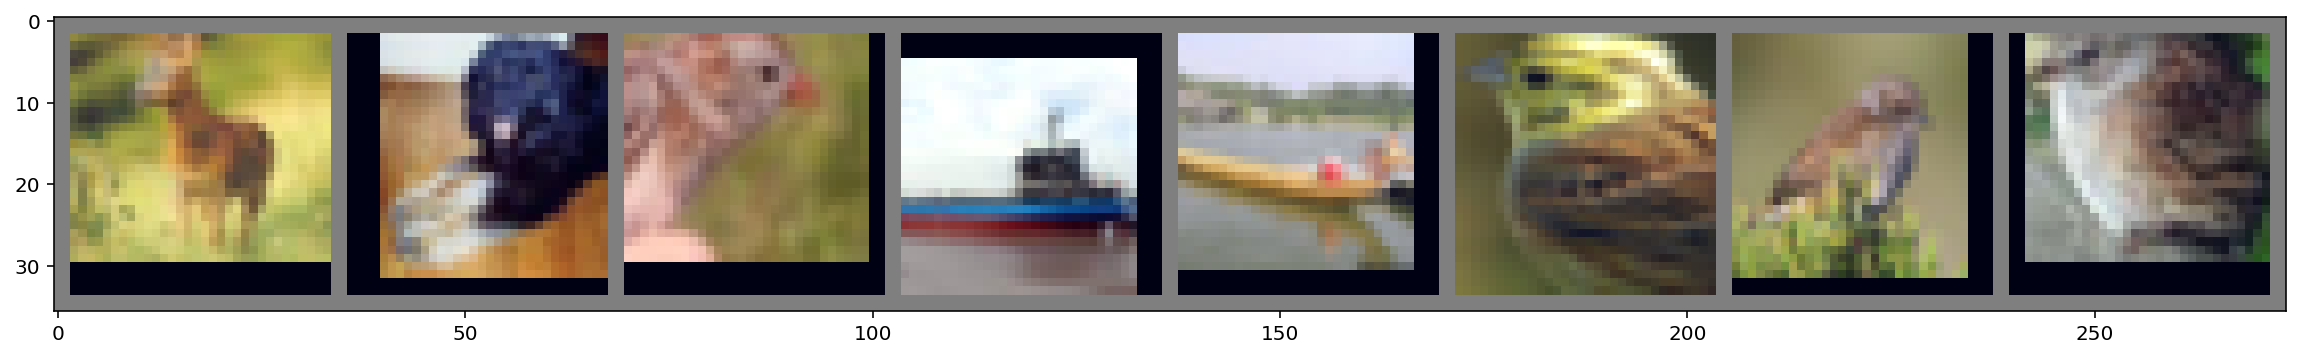

In [19]:
import numpy as np
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# functions to show an image
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
def imshow(img):
    img = img / 4 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
plt.figure(figsize=(20,10)) 

# show images
imshow(torchvision.utils.make_grid(images[0:8,:,:]))
# print labels
print(' '.join('%15s' % classes[labels[j]] for j in range(8)))

class dict and the mean/bias in imshow() only works for Cifar-10, shall change these values while applying different dataset.

In [22]:
import time
import torch.nn as nn

def main(model):
    global args, best_prec1
    
    # Check the save_dir exists or not
    if not os.path.exists(args.save_dir):
        os.makedirs(args.save_dir)
    # define loss function (criterion) and pptimizer
    criterion = nn.CrossEntropyLoss().cuda()

    if args.half:
        print('half persicion is used.')
        model.half()
        criterion.half()
    optimizer = torch.optim.SGD(model.parameters(), args.lr,
                                momentum=args.momentum,
                                weight_decay=args.weight_decay)

    lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100, 150], last_epoch=args.start_epoch - 1)
    model_path = os.path.join(args.save_dir, 'model.pth' )                                                  
    if args.evaluate:
        print('evalution mode')
        model.load_state_dict(torch.load(model_path))
        best_prec1 = validate(val_loader, model, criterion)
        return best_prec1
    ''' 
    if os.path.exists(model_path):
        
    
        model.load_state_dict(torch.load(model_path))
        best_prec1 = validate(val_loader, model, criterion)
        return best_prec1
    '''

    for epoch in range(args.start_epoch, args.epochs):

        # train for one epoch
        
        print('current lr {:.5e}'.format(optimizer.param_groups[0]['lr']))
        train(train_loader, model, criterion, optimizer, epoch)
        lr_scheduler.step()

        # evaluate on validation set
        prec1 = validate(val_loader, model, criterion)

        # remember best prec@1 and save checkpoint
        is_best = prec1 > best_prec1
        best_prec1 = max(prec1, best_prec1)

        if epoch > 0 and epoch % args.save_every == 0:
            save_checkpoint(model.state_dict(), filename=os.path.join(args.save_dir, 'checkpoint.th'))
        if is_best:
            save_checkpoint(model.state_dict(), filename=os.path.join(args.save_dir, 'model.th'))

    return best_prec1
    


In [ ]:

best_prec1 = main(model)
print('The lowest error from {} model after {} epochs is {error:.3f}'.format(args.arch,args.epochs,error=100-best_prec1)) 

current lr 1.00000e-01


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: [0][0/391]	Loss 2.4222 (2.4222)	Prec@1 12.500 (12.500)
Epoch: [0][55/391]	Loss 2.3581 (2.8724)	Prec@1 27.344 (20.020)
Epoch: [0][110/391]	Loss 1.9126 (2.5199)	Prec@1 25.781 (23.599)
Epoch: [0][165/391]	Loss 1.8416 (2.3425)	Prec@1 28.906 (25.697)
Epoch: [0][220/391]	Loss 1.8365 (2.2290)	Prec@1 35.938 (27.259)
Epoch: [0][275/391]	Loss 1.7093 (2.1381)	Prec@1 32.812 (28.810)
Epoch: [0][330/391]	Loss 1.7479 (2.0647)	Prec@1 36.719 (30.235)
Epoch: [0][385/391]	Loss 1.6527 (2.0079)	Prec@1 45.312 (31.499)
Test	  Prec@1: 43.690 (Err: 56.310 )

current lr 1.00000e-01
Epoch: [1][0/391]	Loss 1.6265 (1.6265)	Prec@1 41.406 (41.406)
Epoch: [1][55/391]	Loss 1.4062 (1.5774)	Prec@1 46.875 (42.439)
Epoch: [1][110/391]	Loss 1.6645 (1.5751)	Prec@1 35.156 (42.188)
Epoch: [1][165/391]	Loss 1.4800 (1.5644)	Prec@1 41.406 (42.555)
Epoch: [1][220/391]	Loss 1.4923 (1.5490)	Prec@1 46.094 (43.184)
Epoch: [1][275/391]	Loss 1.3360 (1.5386)	Prec@1 54.688 (43.467)
Epoch: [1][330/391]	Loss 1.3602 (1.5281)	Prec@1 4